# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored in 2016 and has seen impressive results in generating new images; you can read the [original paper, here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. These are color images of different classes, such as airplanes, dogs or trucks. This dataset is much more complex and diverse than the MNIST dataset and justifies the use of the DCGAN architecture.

<img src='assets/cifar10_data.png' width=80% />


So, our goal is to create a DCGAN that can generate new, realistic-looking images. We'll go through the following steps to do this:
* Load in and pre-process the CIFAR10 dataset
* **Define discriminator and generator networks**
* Train these adversarial networks
* Visualize the loss over time and some sample, generated images

In this notebook, we will focus on defining the networks.

#### Deeper Convolutional Networks

Since this dataset is more complex than our MNIST data, we'll need a deeper network to accurately identify patterns in these images and be able to generate new ones. Specifically, we'll use a series of convolutional or transpose convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get these convolutional networks to train. 

Besides these changes in network structure, training the discriminator and generator networks should be the same as before. That is, the discriminator will alternate training on real and fake (generated) images, and the generator will aim to trick the discriminator into thinking that its generated images are real!

In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import random
import pickle as pkl

import tests
# %load_ext autoreload
# %autoreload 2



In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

## Getting the data

Here you can download the CIFAR10 dataset. It's a dataset built-in to the PyTorch datasets library. We can load in training data, transform it into Tensor datatypes, then create dataloaders to batch our data into a desired size.

In [ ]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print("Number of CPU cores:", num_cores)

In [4]:
from torchvision import datasets, transforms

IMAGE_SIZE = 32
CHANNELS_IMG = 3
# Tensor
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)
# (image - mean) / std
# The parameters mean, std are passed as 0.5, 0.5 in this case. 
# This will normalize the image in the range [-1,1]. 
# For example, the minimum value 0 will be converted to (0-0.5)/0.5=-1, 
# the maximum value of 1 will be converted to (1-0.5)/0.5=1.

cifar_train = datasets.CIFAR10(root='data/', train=True, download=True, transform=transforms)


BATCH_SIZE=128

# build DataLoaders for CIFAR10 dataset
train_loader = torch.utils.data.DataLoader(dataset=cifar_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_cores)

Files already downloaded and verified


### Visualize the Data

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real, training images that we'll pass to the discriminator. Notice that each image has _one_ associated, numerical label.

In [5]:
def revert_img(img):
    return (img*0.5)+0.5

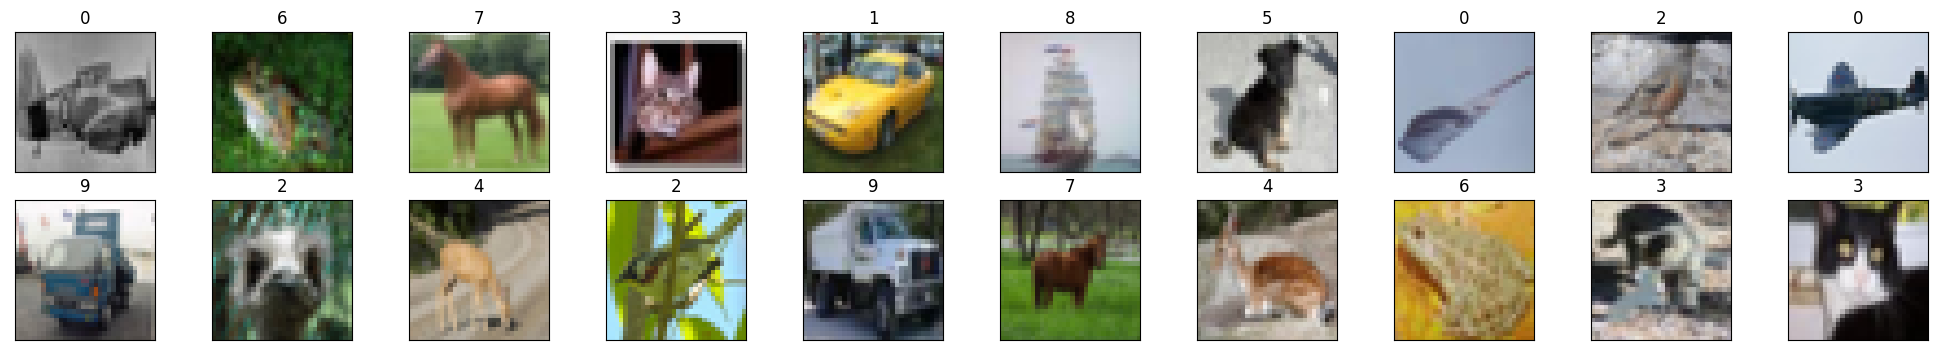

In [6]:
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(revert_img(images[idx]), (1, 2, 0)))
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# # current range
# img = images[0]

# print('Min: ', img.min())
# print('Max: ', img.max())

In [8]:
# # helper scale function
# def scale(x, feature_range=(-1, 1)):
#     ''' Scale takes in an image x and returns that image, scaled
#        with a feature_range of pixel values from -1 to 1. 
#        This function assumes that the input x is already scaled from 0-1.'''
#     # assume x is scaled to (0, 1)
#     # scale to feature_range and return scaled x
#     ####
#     # IMPLEMENT HERE
#     ####
#     x = x * (feature_range[1] - feature_range[0]) + feature_range[0]

#     return x


In [9]:
# # scaled range
# scaled_img = scale(img)

# print('Scaled min: ', scaled_img.min())
# print('Scaled max: ', scaled_img.max())

# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator. Let's use the models we created in the previous exercise.

## Discriminator

Here you'll build the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. 
* The inputs to the discriminator are 32x32x3 tensor images
* You'll want a few convolutional, hidden layers
* Then a fully connected layer for the output; as before, we want a sigmoid output, but we'll add that in the loss function, [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), later

<img src='assets/conv_discriminator.png' width=80%/>

For the depths of the convolutional layers I suggest starting with 32 filters in the first layer, then double that depth as you add layers (to 64, 128, etc.). **Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpooling layers.**

You'll also want to use batch normalization with [nn.BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d) on each layer **except** the first convolutional layer and final, linear output layer. 

#### Helper `_block` module 

In general, each layer should look something like convolution > batch norm > leaky ReLU, and so we'll define a **custom torch Module** to put these layers together. This module will create a sequential series of a convolutional + an optional batch norm layer. 

Note: It is also suggested that you use a **kernel_size of 4** and a **stride of 2** for strided convolutions.

### First exercise

Implement the `_block` module below and use it for your implementation of the `Discriminator` module. Your discriminator should take a 32x32x3 image as input and output a single logit.

In [10]:
class Discriminator(nn.Module):
    """
    The discriminator model adapted from the DCGAN paper. It should only contains a few layers.
    args:
    - conv_dim: control the number of filters
    """
    def __init__(self, conv_dim: int, channels_img: int = 1):
        super().__init__()
        self.conv_dim = conv_dim
        ####
        # IMPLEMENT HERE
        ####
        self.conv1 = self._block(in_channels=channels_img, out_channels=conv_dim, kernel_size=4, bias=True, batch_norm = False) # 32x32 -> 16x16
        self.conv2 = self._block(in_channels=conv_dim, out_channels=conv_dim*2, kernel_size=4, bias=False) # 16x16 -> 8x8
        self.conv3 = self._block(in_channels=conv_dim*2, out_channels=conv_dim*4, kernel_size=4, bias=False) # 8x8 -> 4x4
        self.conv4 = self._block(in_channels=conv_dim*4, out_channels=1, kernel_size=4, padding=0, bias=False) # 4x4 -> 1x1
        
        # get rid of any fully connected layer with respect to the DCGAN paper
        # self.flatten = nn.Flatten()
        # self.fc1 = nn.Linear((4*4)*(conv_dim*4), 1)
    
    def _block(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int = 2, 
                 padding: int = 1,
                 bias: bool = False,
                 batch_norm: bool = True):
        """
        A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
        args:
        - in_channels: number of channels in the input to the conv layer
        - out_channels: number of filters in the conv layer
        - kernel_size: filter dimension of the conv layer
        - batch_norm: whether to use batch norm or not
        """
        if batch_norm:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                # in the DCGAN paper, they say not to use batchnorm on the first layer of descriminator and last layer of generator
                # however, in dicriminator, the bias will be canceled out in the following layers I think! so in the end, we don't have any bias!?
                nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.LeakyReLU(0.2)
            )
    def forward(self, x):
        ####
        # IMPLEMENT HERE
        ####      
        x = self.conv1(x)
        # print(f"shape at conv1: {x.shape}")
        x = self.conv2(x)
        # print(f"shape at conv2: {x.shape}")
        x = self.conv3(x)
        # print(f"shape at conv3: {x.shape}")
        x = self.conv4(x)
        # print(f"shape at conv4: {x.shape}")
        # x = self.flatten(x)
        x = x.squeeze()
        return x

In [11]:
# discriminator = Discriminator(128)
# print(discriminator)

In [12]:
# image_res = 32
# # input_dim: int, padding: int, kernel: int, stride: int, layers: int
# tests.image_size_conv_output(image_res, [1,1,1,0], 4, 2, 4)

In [13]:
# tests.check_discriminator(discriminator, image_res=32)

## Generator

Next, you'll build the generator network. The input will be our noise vector `z`, as before. And, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our CIFAR10 images.

<img src='assets/conv_generator.png' width=80% />

What's new here is we'll use transpose convolutional layers to create our new images. 
* The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x512. 
* Then, we use batch normalization and a leaky ReLU activation. 
* Next is a series of [transpose convolutional layers](https://pytorch.org/docs/stable/nn.html#convtranspose2d), where you typically halve the depth and double the width and height of the previous layer. 
* And, we'll apply batch normalization and ReLU to all but the last of these hidden layers. Where we will just apply a `tanh` activation.

#### Helper `block` module

For each of these layers, the general scheme is transpose convolution > batch norm > ReLU, and so we'll define a function to put these layers together. This function will create a sequential series of a transpose convolutional + an optional batch norm layer. We'll create these using PyTorch's Sequential container, which takes in a list of layers and creates layers according to the order that they are passed in to the Sequential constructor.

Note: It is also suggested that you use a **kernel_size of 4** and a **stride of 2** for transpose convolutions.

#### Second exercise

Implement the `block` module below and use it for your implementation of the `Generator` module. Your generator should take a latent vector of dimension 128 as input and output a 32x32x3 image.

In [14]:
class Generator(nn.Module):
    """
    The generator model adapted from DCGAN
    args:
    - latent_dim: dimension of the latent vector 100x1x1
    - conv_dim: control the number of filters in the convtranspose layers
    """
    def __init__(self, latent_dim: int, conv_dim: int = 128, channels_img: int = 1):
        super().__init__()
        ####
        # IMPLEMENT HERE
        ####
        self.conv_dim = conv_dim
        # self.fc1 = nn.Linear(latent_dim, conv_dim*4*4, bias=False)
        # reshape to (batch_size, conv_dim, 4, 4)
        self.tconv1 = self._block(in_channels=latent_dim, out_channels=conv_dim*4, kernel_size=4, stride=2, padding=0, bias=False)
        self.tconv2 = self._block(in_channels=conv_dim*4, out_channels=conv_dim*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.tconv3 = self._block(in_channels=conv_dim*2, out_channels=conv_dim, kernel_size=4, stride=2, padding=1, bias=False)
        self.tconv4 = self._block(in_channels=conv_dim, out_channels=channels_img, kernel_size=4, stride=2, padding=1, bias=True, batch_norm=False)
    
    
    
    def _block(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int,
                 padding: int,
                 bias: bool = False,
                 batch_norm: bool = True):
        """
        A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
        args:
        - in_channels: number of channels in the input to the conv layer
        - out_channels: number of filters in the conv layer
        - kernel_size: filter dimension of the conv layer
        - stride: stride of the conv layer
        - padding: padding of the conv layer
        - batch_norm: whether to use batch norm or not
        """
        if batch_norm:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.Tanh(),
            )
            
    def forward(self, x):
        ####
        # IMPLEMENT HERE
        ####
        ## x = self.fc1(x)
        ## x = x.view(-1, self.conv_dim, 4, 4)
        # print(f"input {x.shape}")
        x = self.tconv1(x)
        # print(f"shape at conv1: {x.shape}")
        x = self.tconv2(x)
        # print(f"shape at conv2: {x.shape}")
        x = self.tconv3(x)
        # print(f"shape at conv3: {x.shape}")
        x = self.tconv4(x)
        # print(f"shape at conv4: {x.shape}")
        
        return x

In [15]:
# generator = Generator(128)
# print(generator)

In [16]:
# image_res = 1
# # input_dim: int, padding: int, kernel: int, stride: int, layers: int
# tests.image_size_trans_conv_output(image_res, padding=[1,1,1,1], kernel = 2, stride=2, layers = 4)

In [17]:

# # Padding calculator
# output_dim = 4  # Adjust the size as needed
# input_dim = 1
# stride=2
# kernel_size=4

# # Calculate the required padding to match the output size
# padding = ((output_size - 1) // 2)
# padding = ((input_dim - 1) * stride - output_dim + kernel_size) // 2
# print(padding)

In [18]:
# import torch
# import torch.nn as nn

# torch.manual_seed(1)

# input = torch.ones(1, 1, 1, 1)
# upsample = nn.ConvTranspose2d(1, 1, kernel_size=4, stride=2, padding=0)
# output = upsample(input)
# print(f"Output size: {output.size()}")


In [19]:
# tests.check_generator(model=generator, latent_dim=128)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [20]:
# custom weights initialization called on G and D
# it is with respect to the original DCGAN paper
def weights_init(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

In [21]:
Z_DIM = 100
D_FEATURE_DIM = 64
G_FEATURE_DIM = 64
D = Discriminator(D_FEATURE_DIM, CHANNELS_IMG)
G = Generator(Z_DIM, G_FEATURE_DIM, CHANNELS_IMG)

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
D.apply(weights_init);
G.apply(weights_init);
D.to(device);
G.to(device);


In [24]:
print(D)
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
)
Generator(
  (tconv1): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): Bat

---
## Discriminator and Generator Losses

Now we need to calculate the losses. And this will be exactly the same as before.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

The losses will by binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** and binary cross entropy loss in one function.

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the real images with a label = 1, indicating that these are real. The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`. 

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [25]:
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.MSELoss()


In [26]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    #label smoothing
    if smooth:
        labels = torch.ones_like(D_out)*0.9
    else:
        labels = torch.ones_like(D_out)
    # move labels to the GPU
    labels = labels.to(device)
    # calculate the loss
    # squeeze removes dimensions with size 1 from a tensor.
    loss = criterion(D_out.squeeze(), labels)
    
    return loss


def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros_like(D_out)
    # move labels to GPU
    labels = labels.to(device)
    # calculate the loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

Not much new here, but notice how I am using a small learning rate and custom parameters for the Adam optimizers, This is based on some research into DCGAN model convergence.

### Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [27]:
import torch.optim as optim

# IMPLEMENT BELOW
# params
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
beta1 = 0.5
beta2 = 0.999 # default value


d_optimizer = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(beta1, beta2))  
g_optimizer = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(beta1, beta2))

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

**Evaluation mode**

Notice that, when we call our generator to create the samples to display, we set our model to evaluation mode: `G.eval()`. That's so the batch normalization layers will use the population statistics rather than the batch statistics (as they do during training), *and* so dropout layers will operate in eval() mode; not turning off any nodes for generating samples.

In [28]:
from torch.utils.tensorboard import SummaryWriter

In [29]:
# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
fixed_noise = np.random.uniform(-1, 1, size=(32, Z_DIM, 1, 1))
fixed_noise = torch.from_numpy(fixed_noise).float().to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0


2023-10-25 11:34:32.202972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 11:34:38.391748: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-25 11:34:38.391912: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-25 11:34:38.391925: W tensorfl

In [30]:
import torchvision
NUM_EPOCHS = 500
losses = []
samples = []
D.train()
G.train()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(train_loader):
        real = real.to(device)
        noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, Z_DIM, 1, 1))
        noise = torch.from_numpy(noise).float().to(device)
        fake = G(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = D(real)
        loss_disc_real = real_loss(disc_real, smooth=False)
        # The fake input is detached from the generator (while updating the discriminator), so that the generator won’t see any gradients
        # in this way, we don't need torch.no_grads
        disc_fake = D(fake.detach())
        loss_disc_fake = fake_loss(disc_fake)
        loss_disc = (loss_disc_real + loss_disc_fake)/2
        D.zero_grad()
        loss_disc.backward()
        d_optimizer.step()
        
        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = D(fake) # we don't need to worry about gradients of discriminator bcz we only call generator's optimizer to update weights for generator model
                        # https://stackoverflow.com/questions/66841054/when-using-torch-backward-for-a-gans-generator-why-doesnt-discriminator-loss
        loss_gen = real_loss(output, smooth=False)
        G.zero_grad()
        loss_gen.backward()
        g_optimizer.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 400 == 0:
            # append discriminator loss and generator loss
            losses.append((loss_disc.item(), loss_gen.item()))
            print(
                f"Epoch [{epoch+1}/{NUM_EPOCHS}] Batch {batch_idx}/{len(train_loader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}; step: {step}"
            )
    # saving samples can be within batch loop inside if batch_idx%100==0, which means every 100 batch save a sample,
    G.eval()
    with torch.no_grad():
        fake = G(fixed_noise)
        # take out (up to) 32 examples
        img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

        writer_real.add_image("Real", img_grid_real, global_step=step)
        writer_fake.add_image("Fake", img_grid_fake, global_step=step)

        samples.append(fake)
    G.train()
    step += 1
    
# Save training generator samples
with open('train_samples2.pkl', 'wb') as f:
    pkl.dump(samples, f)



Epoch [1/500] Batch 0/391                   Loss D: 0.6924, loss G: 0.6930; step: 0
Epoch [2/500] Batch 0/391                   Loss D: 0.6874, loss G: 0.6914; step: 1
Epoch [3/500] Batch 0/391                   Loss D: 0.6911, loss G: 0.6863; step: 2
Epoch [4/500] Batch 0/391                   Loss D: 0.6902, loss G: 0.6869; step: 3
Epoch [5/500] Batch 0/391                   Loss D: 0.6890, loss G: 0.6896; step: 4
Epoch [6/500] Batch 0/391                   Loss D: 0.6902, loss G: 0.6841; step: 5
Epoch [7/500] Batch 0/391                   Loss D: 0.6936, loss G: 0.6837; step: 6
Epoch [8/500] Batch 0/391                   Loss D: 0.6929, loss G: 0.6858; step: 7
Epoch [9/500] Batch 0/391                   Loss D: 0.6901, loss G: 0.6853; step: 8
Epoch [10/500] Batch 0/391                   Loss D: 0.6896, loss G: 0.6846; step: 9
Epoch [11/500] Batch 0/391                   Loss D: 0.6862, loss G: 0.6803; step: 10
Epoch [12/500] Batch 0/391                   Loss D: 0.6855, loss G: 0.68

In [31]:
torch.save(G.state_dict(), 'Generator.pt')
torch.save(D.state_dict(), 'Discriminator.pt')

## Fusing Convolution with Batch Norm

In [33]:
# from torch.ao.quantization.quantize_fx import fuse_fx
# G.eval()
# fuse_fx(G)

### Show results from tensorboard
* run this in host terminal: tensorboard --logdir=logs
* then open the localhost through the given link
* or run in within notebook as: !tensorboard --logdir=logs
* in case of remote host:
  * forward the localhost port to your local computer using ssh: ssh -L 16006:localhost:6006 root@mzLaptop

In [34]:
# !tensorboard --logdir=logs

## Plot Samples

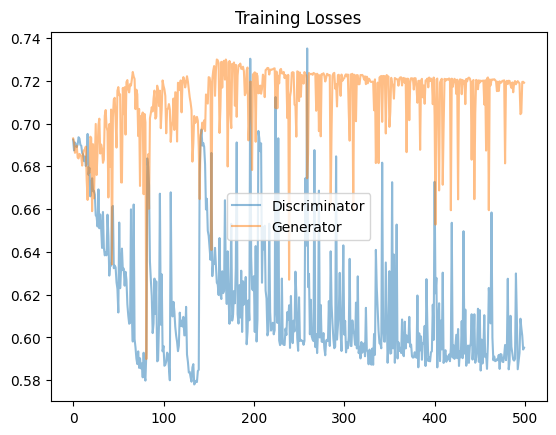

In [32]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [36]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [37]:
print(samples[1].shape)
print(len(samples))

torch.Size([32, 3, 32, 32])
50


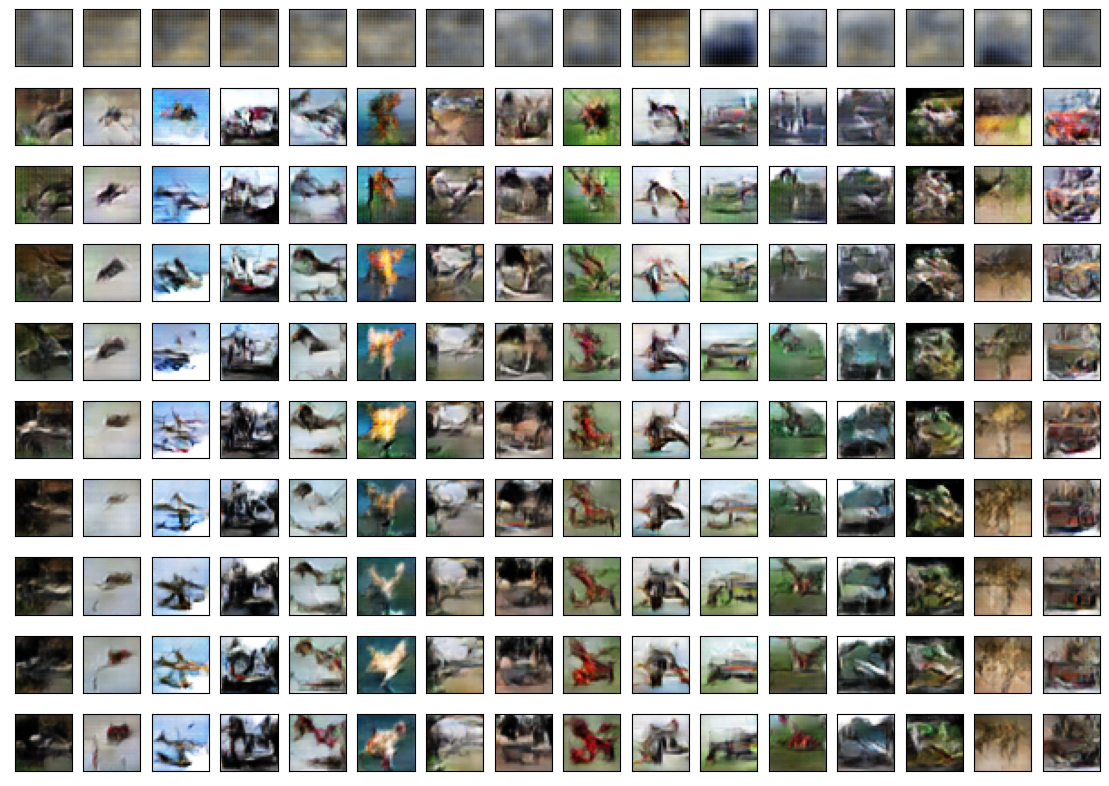

In [33]:
rows = 10 # split epochs into `rows`, so epochs/rows = every _ epochs
cols = 16 # 32 samples/16 column, so every 2 sample plot one of them
fig, axes = plt.subplots(figsize=(14,10), nrows=rows, ncols=cols, sharex=True, sharey=True)
tmp = 0
tmpax = 0
for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        tmp = img
        tmpax = ax
        ax.imshow(np.transpose(revert_img(img.to('cpu')), (1, 2, 0))) # (1, 2, 0) This tuple specifies the new order of the dimensions of the image array.
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        # break

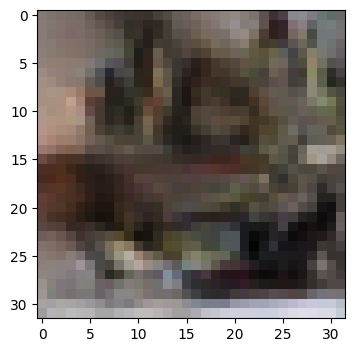

In [34]:
fig, axes = plt.subplots(figsize=(14,4), nrows=1, ncols=1, sharex=True, sharey=True)
axes.imshow(np.transpose(revert_img(tmp.to('cpu')), (1, 2, 0)))

In [35]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(10,6), nrows=4, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = revert_img(img.detach())
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(np.transpose((img.to('cpu')), (1, 2, 0)))
    plt.show()

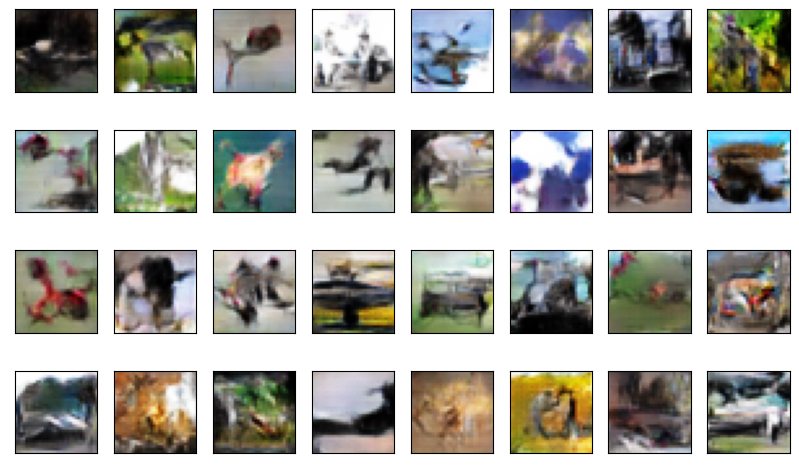

In [36]:
view_samples(-1, samples)

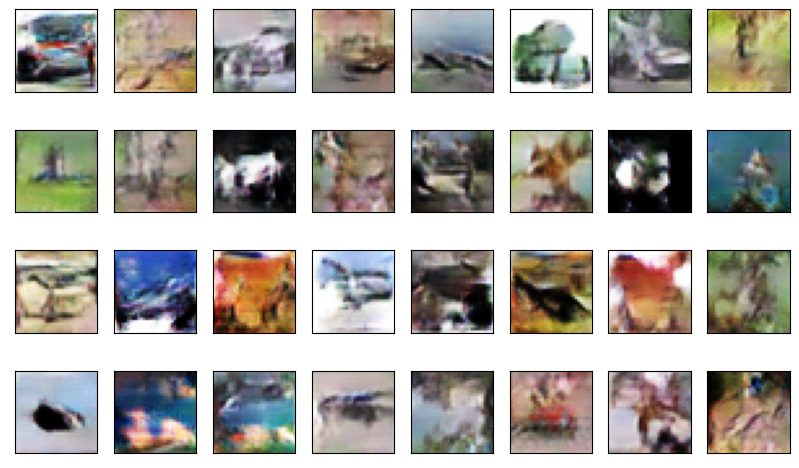

In [45]:
# randomly generated, new latent vectors
sample_size = 800
rand_z = np.random.uniform(-1, 1, size=(sample_size, Z_DIM, 1, 1))
rand_z = torch.from_numpy(rand_z).float()

rand_z = rand_z.to(device)

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

# Save generated samples
with open('GAN_output.pkl', 'wb') as f:
    pkl.dump(rand_images, f)